<!--
SPDX-FileCopyrightText: Copyright (c) 2024 Idiap Research Institute <contact@idiap.ch>
SPDX-FileContributor: Alina Elena Baia <alina.baia.idiap.ch>
SPDX-FileContributor: Darya Baranouskaya <darya.baranouskaya.idiap.ch>
SPDX-FileContributor: Olena Hrynenko <olena.hrynenko.idiap.ch>
-->

# Practice exercises after Lecture 7
This notebook contains the practice exercise with instructions and explanations.

Work through the cells below in sequential order, executing each cell as you progress. Throughout the notebook, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code.
Follow the instructions and write the code to complete the tasks.

Along the way, you will also find questions. Try to reflect on the questions before/after running the code.


This notebook was developed at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch) (equal contribution).

The code of this notebook has been taken and adapted from [Multimodal Transformers toolkit](https://multimodal-toolkit.readthedocs.io/en/latest/) documentation, released under Apache-2.0 license, © Copyright 2020, Ken Gu Revision 8f5b64d5. The complete version is available [here](https://github.com/georgian-io/Multimodal-Toolkit/tree/master).

<!-- A toolkit for incorporating multimodal data on top of text data for classification and regression tasks. This toolkit is heavily based off of HuggingFace Transformers. It adds a combining module that takes the outputs of the transformers in addition to categorical and numerical features to produce rich multimodal features for downstream classification/regression layers. Given a pretrained transformer, the parameters of the combining module and transformer are trained based on the supervised task. -->

<!-- You will learn how to build upon and adapt HuggingFace transformers (i.e. BERT) for integrating tabular data alonside text data for a classification task. -->

You will learn how to **adapt**  transformers (i.e. HuggingFace BERT) to build a **multimodal transformer** that integrates **tabular** data (**categorical** and **numerical**) alonside text data for a classification task. As an exmaple, the classification task consists in classifying clothing review recommendations. You will use the [Womens Clothing E-Commerce Reviews](https://huggingface.co/datasets/Censius-AI/ECommerce-Women-Clothing-Reviews) dataset (Apache-2.0 license).
<!--

 work with example where we classify clothing review recommendations.

Let’s work through an example where we classify clothing review recommendations. We’ll use a simplified version of the example included in the Colab notebook. We will use the Women’s E-Commerce Clothing Reviews from Kaggle, which contains 23,000 customer reviews. -->

The multimodal transformer has "a combining module that takes the outputs of the transformer in addition to categorical and numerical features to produce rich multimodal features for downstream classification/regression layers. Given a pretrained transformer, the parameters of the combining module and transformer are trained based on the supervised task." [cit. [Multimodal Transformers toolkit](https://multimodal-toolkit.readthedocs.io/en/latest/) ]
<!--
A High level diagram of multimodal-transformers. The adaptation of transformers to incorporate data is all contained in the combining module. -->

An overview of the multimodal transformer architecture is shown in the diagram below. "The outputs of a transformer model on text data and tabular features containing categorical and numerical data are combined in a combining module." [cit. [Multimodal Transformers toolkit](https://multimodal-toolkit.readthedocs.io/en/latest/) ]

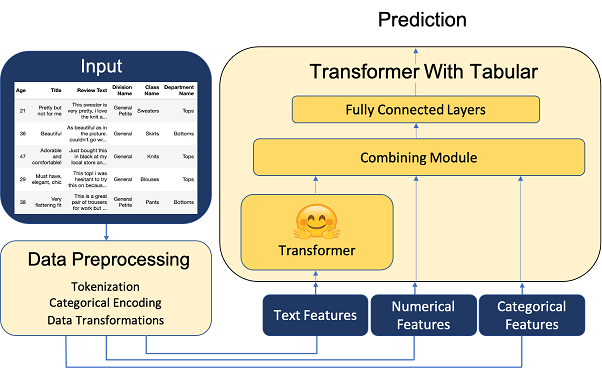

The combining module offers multiple approaches for merging the different modalities.

Notations:

$\mathbf{m}$ - denotes the combined multimodal features

$\mathbf{x}$ - denotes the output text features from the transformer

$\mathbf{c}$ - denotes the categorical features

$\mathbf{n}$ - denotes the numerical features

$h_{\mathbf{\Theta}}$ - denotes a MLP parameterized by $\mathbf{\Theta}$

$\mathbf{W}$ - denotes a weight matrix

$\mathbf{a}$ - denotes a weight matrix

$\Vert$ -  denotes the concatenation operator

The default strategy is **text_only** that "uses just the text columns as processed by transformer before the final classifier layer(s). Essentially is equivalent to HuggingFace's ForSequenceClassification models".

You will implement the following strategies:
 - 7.1 **concat**: "concatenate transformer output, numerical feats, and categorical feats all at once before final classifier layer(s)":

 $\mathbf{m} = \mathbf{x} \, \Vert \, \mathbf{c} \, \Vert \, \mathbf{n}$

 - 7.2 **individual_mlps_on_cat_and_numerical_feats_then_concat**: "separate MLPs on categorical feats and numerical feats then concatenation of transformer output, with processed numerical feats, and processed categorical feats before final classifier layer(s)":

  $\mathbf{m} = \mathbf{x} \, \Vert \, h_{\mathbf{\Theta_c}}( \mathbf{c}) \, \Vert \, h_{\mathbf{\Theta_n}}(\mathbf{n})$

 - 7.3 **attention_on_cat_and_numerical_feats**: "attention based summation of transformer outputs, numerical feats, and categorical feats queried by transformer outputs before final classifier layer(s)

  $\mathbf{m} = \alpha_{x,x}\mathbf{W}_x\mathbf{x} + \alpha_{x,c}\mathbf{W}_c\mathbf{c} + \alpha_{x,n}\mathbf{W}_n\mathbf{n}$ ,  
  
  where the attention coefficients $\alpha_{i,j}$ are computed as:

  $\alpha_{i,j} =\frac{\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}[\mathbf{W}_i\mathbf{x}_i \, \Vert \, \mathbf{W}_j\mathbf{x}_j]\right)\right)}{\sum_{k \in \{ x, c, n \}}\exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}[\mathbf{W}_i\mathbf{x}_i \, \Vert \, \mathbf{W}_k\mathbf{x}_k]\right)\right)}$

<!--
  $\mathbf{W}_x$ is of shape :obj: `(out_dim, text_feat_dim)`,

  $\mathbf{W}_c$ is of shape :obj:`(out_dim, cat_feat_dim)`,

  $\mathbf{W}_n$ is of shape :obj:`(out_dim, num_feat_dim)`,
   -->


The list of all supported combining methods by the multimodal toolkit is available [here](https://multimodal-toolkit.readthedocs.io/en/latest/notes/combine_methods.html).

**IMPORTANT NOTE**: this notebook serves as the main file for the practice exercise and contains the data preparation and model configuration. Make sure to upload the zip with the required files. You will be asked to modified one of the files in the zip.

In [1]:
import os
from zipfile import ZipFile

if not os.path.exists("multimodal_transformers"):
    with ZipFile('multimodal_transformers.zip', 'r') as f:
        f.extractall()



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%ls

LICENSE                   multimodal_transformers.zip  Practice_7.pdf
multimodal_transformers/  Practice_7.ipynb             README.md


In [4]:
import getpass
import os
import re
import torch

# For efficient usage of the hardware resources when running on JupyterHub EPFL,
# we will limit the number of threads. If you are running this code on your local
# machine or on colab, the following code will not do anything.

if getpass.getuser() == "jovyan":
    num_threads_limit = 4
elif re.search('^https://.*noto.*\.epfl\.ch$', os.environ.get("EXTERNAL_URL", "")) != None:
    num_threads_limit = 2
else:
    num_threads_limit = torch.get_num_threads()
print(f"Limiting the number of threads to {num_threads_limit}")
torch.set_num_threads(num_threads_limit)
print(f"PyTorch is using {torch.get_num_threads()} threads")

_ = torch.set_flush_denormal(True) # To avoid long training time on CPU

Limiting the number of threads to 4
PyTorch is using 4 threads


First, install all the necessary HuggingFace libraries:

In [5]:
# If you are using Noto, you might need to install the libraries in your virtual environment and restart the kernel after the installation

# If you are using Google Colab, you can just run the following command:
!pip install transformers datasets evaluate

In [6]:
# If you are using Noto, you might need to install the libraries in your virtual environment and restart the kernel after the installation

# If you are using Google Colab, you can just run the following command:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 4.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.2
    Uninstalling accelerate-0.29.2:
      Successfully uninstalled accelerate-0.29.2


## Dataset

The [Womens Clothing E-Commerce Reviews](https://huggingface.co/datasets/Censius-AI/ECommerce-Women-Clothing-Reviews) dataset contains approximately 23,000 customer reviews about clothing items along with their recommendation: recommended or not recommended.

In [7]:
from datasets import load_dataset
import pandas as pd

#load a dataset form the HuggingFace Hub
dataset = load_dataset("Censius-AI/ECommerce-Women-Clothing-Reviews")

/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word

#### Let us explore the dataset and its content.


In [8]:
data_df = dataset['train'].to_pandas()
data_df.head(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,None,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,None,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


We see that the data contains both text in the `Review Text` and `Title` column. We also have categorical features from the `Clothing ID`, `Division Name`, `Department Name` and `Class Name` columns and numerical features from the `Rating` and `Positive Feedback Count`.

In [9]:
# describe the object-type columns
data_df.describe(include=object)

,Title,Review Text,Division Name,Department Name,Class Name
count,19676,22641,23472,23472,23472
unique,13993,22634,3,6,20
top,Love it!,Perfect fit and i've gotten so many compliment...,General,Tops,Dresses
freq,136,3,13850,10468,6319


In [10]:
# describe the numeric columns
data_df.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


We split our data into training, validation and testing splits. We also save our splits to `train.csv`, `val.csv`, and `test.csv` as this is the format our dataloader requires.

In [11]:
import numpy as np

train_df, val_df, test_df = np.split(data_df.sample(frac=0.4), [int(.2*len(data_df)), int(.3 * len(data_df))])
print('Num examples train-val-test')
print(len(train_df), len(val_df), len(test_df))
train_df.to_csv('train.csv')
val_df.to_csv('val.csv')
test_df.to_csv('test.csv')

Num examples train-val-test
4697 2348 2349


/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Now that we have our data, we need to configure and implement the multimodal transformer. Before doing this, let us have a look at the classes necessary to build the transformer and the organization of the files.

First of all, we need the following classes from [HuggingFace](https://huggingface.co/docs/transformers/v4.39.3/en/index) and Pytorch:
 - [AutoTokenizer](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#autotokenizer): "is a generic tokenizer class that will be instantiated as one of the tokenizer classes of the library when created with the AutoTokenizer.from_pretrained(pretrained_model_name_or_path) class method"
 - [AutoConfig](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#autoconfig): "is a generic configuration class that will be instantiated as one of the configuration classes of the library when created with the from_pretrained() class method"
 - [Trainer](https://huggingface.co/docs/transformers/main/en/trainer): "the Trainer class provides an API for feature-complete training in PyTorch". "Trainer is a simple but feature-complete training and eval loop for PyTorch, optimized for HuggingFace Transformers." Note: the training loop can also be implemented using native Pytorch, as seen in Practice 5. Since the training loop is not the main goal of this notebook, we will use HuggingFace Trainer for faster prototyping.
 - [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments): "offers a wide range of options to customize how a model is trained. Together with Trainer, "these two classes provide a complete training API."
 - [EvalPrediction](https://huggingface.co/transformers/v3.0.2/main_classes/trainer.html?highlight=evalprediction#transformers.EvalPrediction): "evaluation output (always contains labels), to be used to compute metrics."
 - [Pytorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html): "allows you to use pre-loaded datasets as well as your own data".


The multimodal transformer, uses the above mentioned classes, and defines custom classes and utilities functions specific for the multimodality classification task, such as:
  - load_data_from_folder located in `/data/load_data.py`: "function to load train, test and/or validation text and tabular data from specified folder path into TorchTextDataset class and does categorical and numerical  data preprocessing if specified."
  - TabularFeatCombiner class located in `/model/tabular_combiner.py`: combiner module for combining text features with categorical and numerical features. **SPOILER ALERT**: you will implement the combinining strategies in the `/model/tabular_combiner.py` file
  - TabularConfig class located in `/model/tabular_config.py`: used to configure the combiner module TabularFeatCombiner
  -AutoModelWithTabular class located in `/model/tabular_modeling_auto`: is designed to be instantiated using, for example, the `AutoModelWithTabular.from_pretrained(pretrained_model_name_or_path)` which instantiates one of the sequence classification model classes of the library from a pre-trained model configuration, i.e. BertWithTabular.
   List of supported transformer models is available [here](https://github.com/georgian-io/Multimodal-Toolkit/blob/master/multimodal_transformers/model/tabular_transformers.py)
  -BertWithTabular class located in `/model/tabular_transformers.py`: inherits from [BertForSequenceClassification](https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#bertforsequenceclassification) and it defines a "Bert Model transformer with a sequence classification head as well as a TabularFeatCombiner module to combine categorical and numerical features     with the Bert pooled output."



Overview of the interactions between the various elements necessary to create and train the multimodal transformer.

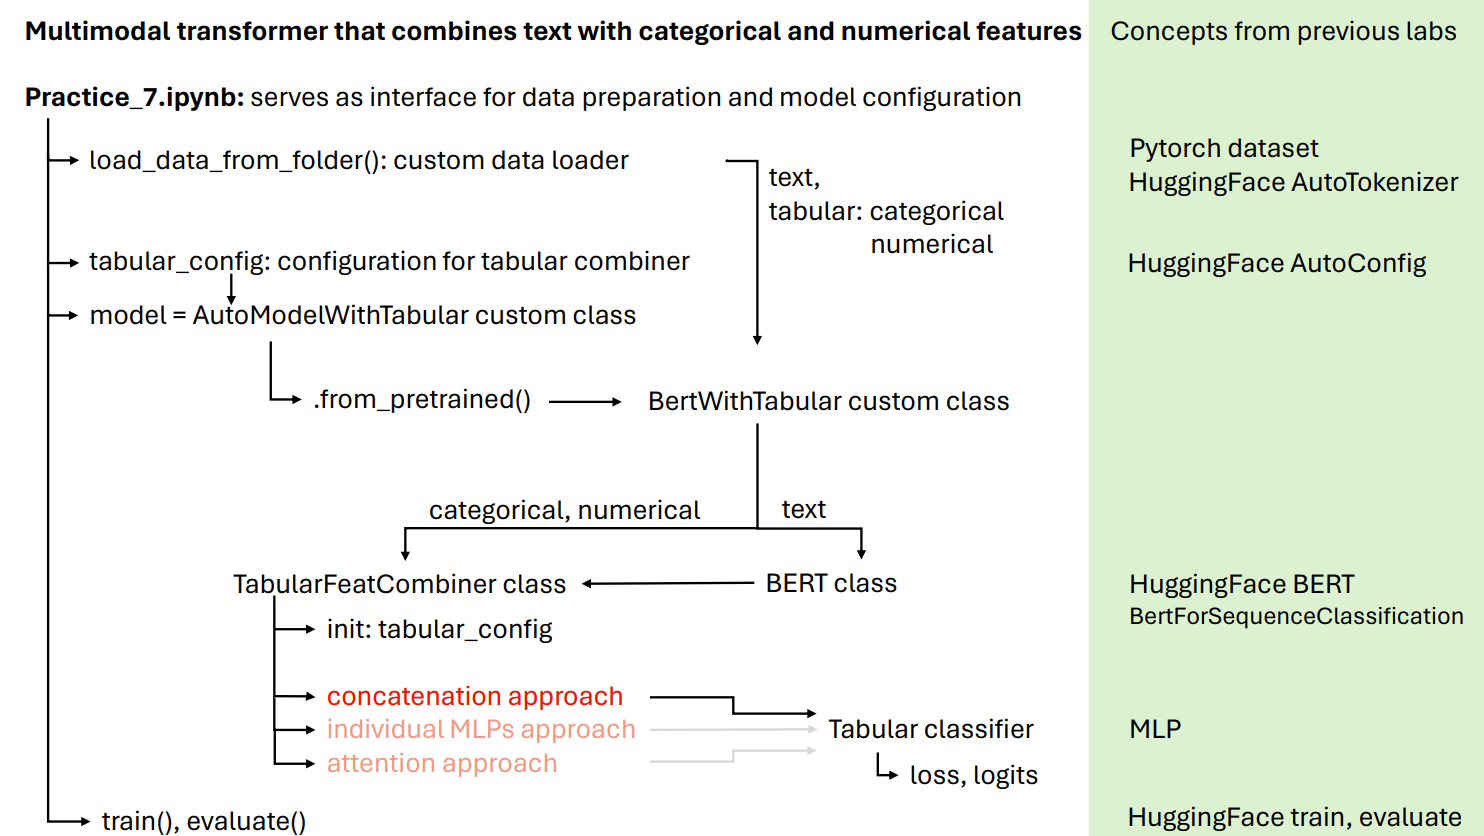

  

  **Recommendation**: take a few minutes to explore the organization and structure of the files, and try to answer the following questions.


  **Question**: Did you find where the combining module is being used? What are the inputs to the combining module?

  **Question**: How are the features processed after combining them?

  **Question**: Find `hf_loss_func`. What does `hf_loss_func` do?

Now that we know how the files are organized, we can proceed with the configuration of the multimodal transformer.

In [12]:
from dataclasses import dataclass, field
import json
# tracking events that happen when the code is running
import logging
import os
from typing import Optional

import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoConfig, Trainer, EvalPrediction, set_seed
from transformers.training_args import TrainingArguments

import sys

from multimodal_transformers.data import load_data_from_folder
from multimodal_transformers.model import TabularConfig
from multimodal_transformers.model import AutoModelWithTabular


We use Data Classes to hold each of our arguments for the model, data, and training.  "A data class is a class typically containing mainly data, although there aren't really any restrictions. It is created using the new @dataclass decorator, as follows (cit. [source](https://realpython.com/python-data-classes/)):

In [13]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={
            "help": "Path to pretrained model or model identifier from huggingface.co/models"
        }
    )
    config_name: Optional[str] = field(
        default=None,
        metadata={
            "help": "Pretrained config name or path if not the same as model_name"
        },
    )
    tokenizer_name: Optional[str] = field(
        default=None,
        metadata={
            "help": "Pretrained tokenizer name or path if not the same as model_name"
        },
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={
            "help": "Where do you want to store the pretrained models downloaded from s3"
        },
    )


@dataclass
class MultimodalDataTrainingArguments:
    """
    Arguments pertaining to how we combine tabular features
    Using `HfArgumentParser` we can turn this class
    into argparse arguments to be able to specify them on
    the command line.
    """

    data_path: str = field(
        metadata={"help": "the path to the csv file containing the dataset"}
    )
    column_info_path: str = field(
        default=None,
        metadata={
            "help": "the path to the json file detailing which columns are text, categorical, numerical, and the label"
        },
    )

    column_info: dict = field(
        default=None,
        metadata={
            "help": "a dict referencing the text, categorical, numerical, and label columns"
            "its keys are text_cols, num_cols, cat_cols, and label_col"
        },
    )

    categorical_encode_type: str = field(
        #ohe: one-hot encoding
        default="ohe",
        metadata={
            "help": "sklearn encoder to use for categorical data",
            "choices": ["ohe", "binary", "label", "none"],
        },
    )
    numerical_transformer_method: str = field(
        # more details: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
        default="yeo_johnson",
        metadata={
            "help": "sklearn numerical transformer to preprocess numerical data",
            "choices": ["yeo_johnson", "box_cox", "quantile_normal", "none"],
        },
    )
    task: str = field(
        default="classification",
        metadata={
            "help": "The downstream training task",
            "choices": ["classification", "regression"],
        },
    )

    mlp_division: int = field(
        default=4,
        metadata={
            "help": "the ratio of the number of "
            "hidden dims in a current layer to the next MLP layer"
        },
    )
    ## NOTE: you will implement different combination methods
    combine_feat_method: str = field(
        default="individual_mlps_on_cat_and_numerical_feats_then_concat",
        metadata={
            "help": "method to combine categorical and numerical features, "
            "see README for all the methods"
        },
    )
    mlp_dropout: float = field(
        default=0.1, metadata={"help": "dropout ratio used for MLP layers"}
    )
    numerical_bn: bool = field(
        default=True,
        metadata={"help": "whether to use batchnorm on numerical features"},
    )
    categorical_bn: bool = field(
        default=True,
        metadata={"help": "whether to use batchnorm on categorical features"},
    )
    use_simple_classifier: str = field(
        default=True,
        metadata={"help": "whether to use single layer or MLP as final classifier"},
    )
    mlp_act: str = field(
        default="relu",
        metadata={
            "help": "the activation function to use for finetuning layers",
            "choices": ["relu", "prelu", "sigmoid", "tanh", "linear"],
        },
    )

    # https://docs.python.org/3/library/dataclasses.html#dataclasses.__post_init__
    # https://stackoverflow.com/questions/73672582/when-the-method-post-init-doesnt-called
    def __post_init__(self):
        assert self.column_info != self.column_info_path
        if self.column_info is None and self.column_info_path:
            with open(self.column_info_path, "r") as f:
                self.column_info = json.load(f)

### Data and training parameters.
"For model we can specify any supported HuggingFace model classes (more details [here](https://github.com/georgian-io/Multimodal-Toolkit/tree/master)) as well as any AutoModel that are from the supported model classes. For the data specifications, we need to specify a dictionary that specifies which columns are the `text` columns, `numerical feature` columns, `categorical feature` column, and the `label` column. If we are doing classification, we can also specify what each of the labels means in the label column through the `label list`. We can also specifiy these columns using a path to a json file with the argument `column_info_path` to `MultimodalDataTrainingArguments`." [cit. [Multimodal transformers toolkit](https://multimodal-toolkit.readthedocs.io/en/latest/)]

This notebook uses [BERT-tiny model](https://github.com/google-research/bert/blob/master/README.md), named "google/bert_uncased_L-2_H-128_A-2". We use it for teaching purposes as it requires fewer computational resources and it allows fast training on CPU.

In [14]:
# columns containing text data
text_cols = ["Title", "Review Text"]

# columns containing categorial features
cat_cols = ["Clothing ID", "Division Name", "Department Name", "Class Name"]

# columns containing numerical features
numerical_cols = ["Rating", "Age", "Positive Feedback Count"]

column_info_dict = {
    "text_cols": text_cols,
    "num_cols": numerical_cols,
    "cat_cols": cat_cols,
    "label_col": "Recommended IND",
    "label_list": ["Not Recommended", "Recommended"],
}

# google/bert_uncased_L-2_H-128_A-2 license

# Copyright 2018 The Google AI Language Team Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

model_args = ModelArguments(model_name_or_path="google/bert_uncased_L-2_H-128_A-2")

data_args = MultimodalDataTrainingArguments(
    data_path=".",

    ## NOTE: to use different combination methods change here the combine_feat_method
    ## i.e. for concatenation method: combine_feat_method = "concat"
    ## for individual mlp: combine_feat_method = "individual_mlps_on_cat_and_numerical_feats_then_concat"
    ## for attention : combine_feat_method = "attention_on_cat_and_numerical_feats"

    combine_feat_method="text_only",
    column_info=column_info_dict,
    task="classification",
)

# specifying the training arguments
training_args = TrainingArguments(
    output_dir="./logs/model_name",
    logging_dir="./logs/runs",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    logging_steps=25,
    eval_steps=250,
)

set_seed(training_args.seed)

### Load our data and model.

We first instantiate our HuggingFace tokenizer.
This is needed to prepare our custom torch dataset. See /data/tabular_torch_dataset.py for details.

In [15]:
tokenizer_path_or_name = model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path
print('Specified tokenizer: ', tokenizer_path_or_name)
tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_path_or_name,
    model_max_lenght=512,
    cache_dir=model_args.cache_dir,
)

Specified tokenizer:  google/bert_uncased_L-2_H-128_A-2


config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Use `load_data_from_folder`  to load tha csv dataset to torch dataset.
`load_data_from_folder` expects a path to a folder that contains `train.csv`, `test.csv`, and/or `val.csv` containing the respective split datasets.

In [16]:
# Get Datasets
train_dataset, val_dataset, test_dataset = load_data_from_folder(
    data_args.data_path,
    data_args.column_info["text_cols"],
    tokenizer,
    label_col=data_args.column_info["label_col"],
    label_list=data_args.column_info["label_list"],
    categorical_cols=data_args.column_info["cat_cols"],
    numerical_cols=data_args.column_info["num_cols"],
    sep_text_token_str=tokenizer.sep_token,
)

# define number of labels
num_labels = len(np.unique(train_dataset.labels))
num_labels

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


2

Next, "load our transformer with a tabular model. First, we specify our tabular configurations in a TabularConfig object. This config is then set as the tabular_config member variable of a HuggingFace transformer config object. [cit. [Multimodal transformers](https://medium.com/georgian-impact-blog/how-to-incorporate-tabular-data-with-huggingface-transformers-b70ac45fcfb4)]

In [17]:
# defining the configuration of the model and the combiner module

config = AutoConfig.from_pretrained(
    model_args.config_name if model_args.config_name else model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
)
tabular_config = TabularConfig(
    num_labels=num_labels,
    cat_feat_dim=train_dataset.cat_feats.shape[1],
    numerical_feat_dim=train_dataset.numerical_feats.shape[1],
    **vars(data_args)
)
config.tabular_config = tabular_config

In [18]:
# load the transformer with tabular mode
model = AutoModelWithTabular.from_pretrained(
    model_args.config_name if model_args.config_name else model_args.model_name_or_path,
    config=config,
    cache_dir=model_args.cache_dir,
)

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Some weights of BertWithTabular were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'tabular_classifier.bias', 'tabular_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Metrics


In [19]:
import numpy as np
from scipy.special import softmax
from sklearn.metrics import (
    auc,
    precision_recall_curve,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    matthews_corrcoef,
)


def calc_classification_metrics(p: EvalPrediction):
    predictions = p.predictions[0]
    pred_labels = np.argmax(predictions, axis=1)
    pred_scores = softmax(predictions, axis=1)[:, 1]
    labels = p.label_ids
    if len(np.unique(labels)) == 2:  # binary classification
        roc_auc_pred_score = roc_auc_score(labels, pred_scores)
        precisions, recalls, thresholds = precision_recall_curve(labels, pred_scores)
        fscore = (2 * precisions * recalls) / (precisions + recalls)
        fscore[np.isnan(fscore)] = 0
        ix = np.argmax(fscore)
        threshold = thresholds[ix].item()
        pr_auc = auc(recalls, precisions)
        tn, fp, fn, tp = confusion_matrix(labels, pred_labels, labels=[0, 1]).ravel()
        result = {
            "roc_auc": roc_auc_pred_score,
            "threshold": threshold,
            "pr_auc": pr_auc,
            "recall": recalls[ix].item(),
            "precision": precisions[ix].item(),
            "f1": fscore[ix].item(),
            "tn": tn.item(),
            "fp": fp.item(),
            "fn": fn.item(),
            "tp": tp.item(),
        }
    else:
        acc = (pred_labels == labels).mean()
        f1 = f1_score(y_true=labels, y_pred=pred_labels)
        result = {
            "acc": acc,
            "f1": f1,
            "acc_and_f1": (acc + f1) / 2,
            "mcc": matthews_corrcoef(labels, pred_labels),
        }

    return result

For training, we use HuggingFace's trainer class.

(Reminder: training loop can also be implemented using native Pytorch. For convenience, we are using HuggingFace Trainer)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=calc_classification_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Call `train()` to launch the training.

In [22]:
%%time
trainer.train()

Step,Training Loss
25,0.571600
50,0.489200
75,0.507800
100,0.461400
125,0.449100


CPU times: user 1min 18s, sys: 3.38 s, total: 1min 21s
Wall time: 1min 37s


TrainOutput(global_step=147, training_loss=0.4879353711394226, metrics={'train_runtime': 97.5422, 'train_samples_per_second': 48.154, 'train_steps_per_second': 1.507, 'total_flos': 1912650114144.0, 'train_loss': 0.4879353711394226, 'epoch': 1.0})

Evaluate the model on the validation dataset using `evaluate()`

In [ ]:
trainer.evaluate(eval_dataset= val_dataset)

{'eval_loss': 0.4362088143825531,
 'eval_roc_auc': 0.7922106254803283,
 'eval_threshold': 0.7015708088874817,
 'eval_pr_auc': 0.9435574364793151,
 'eval_recall': 0.9875647668393782,
 'eval_precision': 0.839647577092511,
 'eval_f1': 0.9076190476190477,
 'eval_tn': 0,
 'eval_fp': 418,
 'eval_fn': 0,
 'eval_tp': 1930,
 'eval_runtime': 13.9352,
 'eval_samples_per_second': 168.494,
 'eval_steps_per_second': 5.31,
 'epoch': 1.0}

Here's an example of performing inference with Pytorch Native, by running the trained model on a test batch of size 32. Note that to test a single example, you should still pass it as a batch to the model

In [ ]:
test_batch = test_dataset[:32]
test_batch.keys()

model.eval()
with torch.no_grad():
    _, logits, classifier_outputs = model(
        test_batch["input_ids"],
        attention_mask=test_batch["attention_mask"],
        token_type_ids=test_batch["token_type_ids"],
        cat_feats=test_batch["cat_feats"],
        numerical_feats=test_batch["numerical_feats"],
    )

acc = torch.sum(logits.argmax(axis=1) == test_batch["labels"]) / logits.shape[0]
print(f"Accuracy: {acc}")

Accuracy: 0.71875


Now that you have an understanding of the files and overall model configuration, you can go ahead and implement the combine methods.
For this, you will have to implement the formulas reported at the begining of this notebook in ./model/tabular_combiner.py. Additional details are provided in this file.

We recommend starting with **concat**, then continue with **individual_mlps_on_cat_and_numerical_feats_then_concat** and conclude with **attention_on_cat_and_numerical_feats**.

Happy multimodality coding!